In [1]:
from pynq import Overlay, allocate
import matplotlib.pyplot as plt
import pynq_composable
import numpy as np
import math
from PIL import Image 

ol = Overlay("commun.bit")
cfilter = ol.comm
print(f"Parent class: {cfilter.__class__.__bases__}, driver: {type(cfilter)}")
cfilter.c_dict

Parent class: (<class 'pynq.overlay.DefaultHierarchy'>,), driver: <class 'pynq_composable.composable.Composable'>


{'pixl_to_symbol_0': {'ci': [0],
  'dfx': False,
  'loaded': True,
  'modtype': 'pixl_to_symbol',
  'pi': [0]},
 'symbol_to_pixl_0': {'ci': [1],
  'dfx': False,
  'loaded': True,
  'modtype': 'symbol_to_pixl',
  'pi': [2]},
 'encoder_0': {'ci': [2],
  'dfx': False,
  'loaded': True,
  'modtype': 'encoder',
  'pi': [3]},
 'decoder_0': {'ci': [4],
  'dfx': False,
  'loaded': True,
  'modtype': 'decoder',
  'pi': [4]},
 'QAM_0': {'ci': [5],
  'dfx': False,
  'loaded': True,
  'modtype': 'QAM',
  'pi': [5]},
 'deQAM_0': {'ci': [6],
  'dfx': False,
  'loaded': True,
  'modtype': 'deQAM',
  'pi': [6]},
 'pilot_insertion_0': {'ci': [7],
  'dfx': False,
  'loaded': True,
  'modtype': 'pilot_insertion',
  'pi': [7]},
 'equalizer_pilot_remo_0': {'ci': [8],
  'dfx': False,
  'loaded': True,
  'modtype': 'equalizer_pilot_removal',
  'pi': [8]},
 'fft_top0_0': {'ci': [9],
  'dfx': False,
  'loaded': True,
  'modtype': 'fft_top0',
  'pi': [9]},
 'fft_top1_0': {'ci': [10],
  'dfx': False,
  'loaded':

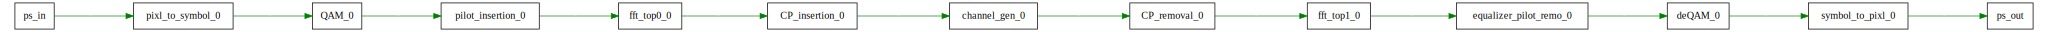

In [12]:
# channel_total => ok
cfilter.compose([cfilter.ps_in, cfilter.pixl_to_symbol_0, cfilter.QAM_0, cfilter.pilot_insertion_0, cfilter.fft_top0_0, cfilter.CP_insertion_0, cfilter.channel_gen_0, cfilter.CP_removal_0, cfilter.fft_top1_0, cfilter.equalizer_pilot_remo_0, cfilter.deQAM_0, cfilter.symbol_to_pixl_0, cfilter.ps_out])
cfilter.graph

In [2]:
# ecc => ok
cfilter.compose([cfilter.ps_in, cfilter.pixl_to_symbol_0, cfilter.encoder_0, cfilter.QAM_0, cfilter.pilot_insertion_0, cfilter.fft_top0_0, cfilter.CP_insertion_0, cfilter.channel_gen_0, cfilter.CP_removal_0, cfilter.fft_top1_0, cfilter.equalizer_pilot_remo_0, cfilter.deQAM_0, cfilter.decoder_0, cfilter.symbol_to_pixl_0, cfilter.ps_out])
cfilter.graph

#-----------------ORIGIANL PIC--------------------#


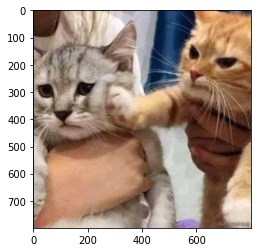

#-----------------READ DATA OK--------------------#
#-------------------DATA SET----------------------#
#-----------------KERNEL START--------------------#
#------------------KERNEL END---------------------#
BER =  1.5298680642469753


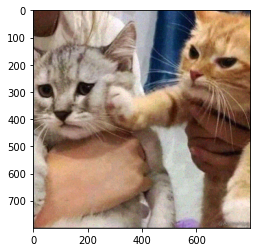

#------------------PROCESS END---------------------#


In [13]:
dma_send = ol.axi_dma.sendchannel
dma_recv = ol.axi_dma.recvchannel

module_id = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12])
len_module_id = len(module_id)
len_parameter_id = [4,4,4,4,3,4,6,4,3,5,4,4,4] # # of parameters in each module
parameter_sum = sum(len_parameter_id)

qam_num = 16
sym_num = 2
pilot_width = 4
CP_length = 16
TAPS_NUM = 1
SNR = 15
FFT_len = 64
    
RGB_val = 3
print("#-----------------ORIGIANL PIC--------------------#")
cat_pic = Image.open("cat_punch.jpg")
plt.imshow(cat_pic)
plt.show()
cat_pic = cat_pic.rotate(270)
cat_pic = cat_pic.transpose(Image.FLIP_LEFT_RIGHT)
pic_array = allocate(shape=((cat_pic.size[0]*cat_pic.size[1]*3),), dtype=np.uint8)
for inx1 in range(cat_pic.size[0]):
    for inx2 in range(cat_pic.size[1]):
            pix = cat_pic.getpixel((inx1,inx2))
            pic_array[(inx1)*(cat_pic.size[1])*RGB_val+(inx2)*RGB_val+0] = pix[0]
            pic_array[(inx1)*(cat_pic.size[1])*RGB_val+(inx2)*RGB_val+1] = pix[1]
            pic_array[(inx1)*(cat_pic.size[1])*RGB_val+(inx2)*RGB_val+2] = pix[2]
print("#-----------------READ DATA OK--------------------#")

numSamples = cat_pic.size[0]*cat_pic.size[1]*3
input_compensate = (int)(((FFT_len-(FFT_len/pilot_width))/sym_num)-(numSamples%((FFT_len-(FFT_len/pilot_width))/sym_num)))
data_len = numSamples + input_compensate
total_input_num = data_len + parameter_sum + 1
in_num_sample = parameter_sum + 1 + data_len
out_num_sample = parameter_sum + 1 + data_len

input_buffer = allocate(shape=(in_num_sample,), dtype=np.uint64)
output_buffer = allocate(shape=(out_num_sample,), dtype=np.uint64)

BER = [0]
out_pic = allocate(shape=((cat_pic.size[0]*cat_pic.size[1]*3),), dtype=np.uint64)

parameter_id = np.array([[data_len,qam_num,sym_num,pilot_width], # module_id = 0 pixl2sym
                         [data_len,qam_num,sym_num,pilot_width], # module_id = 1 encoder
                         [data_len,qam_num,sym_num,pilot_width], # module_id = 2 QAM
                         [data_len,sym_num,pilot_width,CP_length], # module_id = 3 pilot insert
                         [data_len,sym_num,pilot_width], # module_id = 4 IFFT
                         [data_len,sym_num,pilot_width,CP_length], # module_id = 5 CP insert
                         [data_len,sym_num,pilot_width,CP_length,TAPS_NUM,SNR], # module_id = 6 channel
                         [data_len,sym_num,pilot_width,CP_length], # module_id = 7 CP remove
                         [data_len,sym_num,pilot_width], # module_id = 8 FFT
                         [data_len,sym_num,pilot_width,CP_length, TAPS_NUM], # module_id = 9 pilot remove
                         [data_len,qam_num,sym_num,pilot_width], # module_id = 10 deQAM
                         [data_len,qam_num,sym_num,pilot_width], # module_id = 11 decoder
                         [data_len,qam_num,sym_num,pilot_width]],dtype=object)# module_id = 12 sym2pixl

print("#-------------------PARA SET----------------------#")
temp = allocate(shape=(1,), dtype=np.uint64)
cnt_para_in = 0
for i in range(len_module_id):
    temp[0] = module_id[i] * pow(2,16) 
    for j in range(len_parameter_id[i]):
        input_buffer[cnt_para_in+j] = temp[0]
        input_buffer[cnt_para_in+j] = input_buffer[cnt_para_in+j] + j
        input_buffer[cnt_para_in+j] = input_buffer[cnt_para_in+j] * pow(2,32)
        input_buffer[cnt_para_in+j] = input_buffer[cnt_para_in+j] + parameter_id[i][j]
    cnt_para_in = cnt_para_in+len_parameter_id[i]
input_buffer[parameter_sum] = (pow(2,16)-1)*pow(2,48)

print("#-------------------DATA SET----------------------#")
for k in range(data_len):
    if (k<numSamples):
        input_buffer[parameter_sum+k+1] = pic_array[k]
    else:
        input_buffer[parameter_sum+k+1] = 0

print("#-----------------KERNEL START--------------------#")
dma_send.transfer(input_buffer)
dma_recv.transfer(output_buffer)
dma_send.wait()
dma_recv.wait()
print("#------------------KERNEL END---------------------#")

para_out_cnt = 0
while (output_buffer[para_out_cnt]/math.pow(2,48) != 65535):
    para_out_cnt = para_out_cnt + 1

ber = 0
pixl_length = 8

for k in range(numSamples):
    err = '{:08b}'.format(output_buffer[k+para_out_cnt+1]^(input_buffer[k+parameter_sum+1])).count('1')
    ber = ber + err
    out_pic[k] = output_buffer[k+para_out_cnt+1]

BER = ber/numSamples/pixl_length*100
print("BER = ", BER, "%");

out_pic_matrix = out_pic.reshape(cat_pic.size[0],cat_pic.size[1],3)
plt.imshow(out_pic_matrix)
plt.show()
print("#------------------PROCESS END---------------------#")

#-----------------ORIGIANL PIC--------------------#


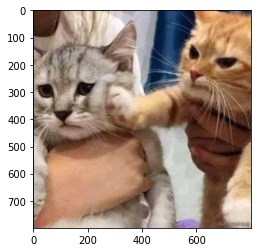

#-----------------READ DATA OK--------------------#
#-------------------PARA SET----------------------#
#-------------------DATA SET----------------------#
#-----------------KERNEL START--------------------#
#------------------KERNEL END---------------------#
BER =  0.0023336462244472255


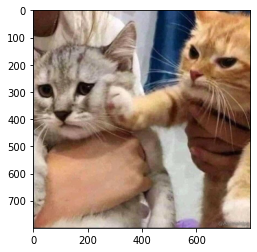

#------------------PROCESS END---------------------#


In [3]:
# ecc host => OK

dma_send = ol.axi_dma.sendchannel
dma_recv = ol.axi_dma.recvchannel

module_id = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12])
len_module_id = len(module_id)
len_parameter_id = [4,4,4,4,3,4,6,4,3,5,4,4,4] # # of parameters in each module
parameter_sum = sum(len_parameter_id)

qam_num = 16
sym_num = 2
pilot_width = 4
CP_length = 16
TAPS_NUM = 1
SNR = [15]
FFT_len = 64 

RGB_val = 3
print("#-----------------ORIGIANL PIC--------------------#")
cat_pic = Image.open("cat_punch.jpg")
plt.imshow(cat_pic)
plt.show()
cat_pic = cat_pic.rotate(270)
cat_pic = cat_pic.transpose(Image.FLIP_LEFT_RIGHT)
pic_array = allocate(shape=((cat_pic.size[0]*cat_pic.size[1]*3),), dtype=np.uint8)
for inx1 in range(cat_pic.size[0]):
    for inx2 in range(cat_pic.size[1]):
        pix = cat_pic.getpixel((inx1,inx2))
        pic_array[(inx1)*(cat_pic.size[1])*RGB_val+(inx2)*RGB_val+0] = pix[0]
        pic_array[(inx1)*(cat_pic.size[1])*RGB_val+(inx2)*RGB_val+1] = pix[1]
        pic_array[(inx1)*(cat_pic.size[1])*RGB_val+(inx2)*RGB_val+2] = pix[2]
print("#-----------------READ DATA OK--------------------#")

numSamples = cat_pic.size[0]*cat_pic.size[1]*3
input_compensate = (int)(((FFT_len-(FFT_len/pilot_width))/sym_num)-((numSamples+4)%((FFT_len-(FFT_len/pilot_width))/sym_num)))
data_len = numSamples + 4 + input_compensate
total_input_num = data_len + parameter_sum + 1
in_num_sample = parameter_sum + 1 + data_len
out_num_sample = parameter_sum + 1 + data_len

input_buffer = allocate(shape=(in_num_sample,), dtype=np.uint64)
output_buffer = allocate(shape=(out_num_sample,), dtype=np.uint64)

BER = [0]*len(SNR)
out_pic = allocate(shape=((cat_pic.size[0]*cat_pic.size[1]*3),), dtype=np.uint64)

parameter_id = np.array([[data_len,qam_num,sym_num,pilot_width], # module_id = 0 pixl2sym
                         [data_len,qam_num,sym_num,pilot_width], # module_id = 1 encoder
                         [data_len*2,qam_num,sym_num,pilot_width], # module_id = 2 QAM
                         [data_len*2,sym_num,pilot_width,CP_length], # module_id = 3 pilot insert
                         [data_len*2,sym_num,pilot_width], # module_id = 4 IFFT
                         [data_len*2,sym_num,pilot_width,CP_length], # module_id = 5 CP insert
                         [data_len*2,sym_num,pilot_width,CP_length,TAPS_NUM,SNR], # module_id = 6 channel
                         [data_len*2,sym_num,pilot_width,CP_length], # module_id = 7 CP remove
                         [data_len*2,sym_num,pilot_width], # module_id = 8 FFT
                         [data_len*2,sym_num,pilot_width,CP_length, TAPS_NUM], # module_id = 9 pilot remove
                         [data_len*2,qam_num,sym_num,pilot_width], # module_id = 10 deQAM
                         [data_len,qam_num,sym_num,pilot_width], # module_id = 11 decoder
                         [data_len-4,qam_num,sym_num,pilot_width]],dtype=object)# module_id = 12 sym2pixl

print("#-------------------PARA SET----------------------#")
temp = allocate(shape=(1,), dtype=np.uint64)
cnt_para_in = 0
for i in range(len_module_id):
    temp[0] = module_id[i] * pow(2,16) 
    for j in range(len_parameter_id[i]):
        input_buffer[cnt_para_in+j] = temp[0]
        input_buffer[cnt_para_in+j] = input_buffer[cnt_para_in+j] + j
        input_buffer[cnt_para_in+j] = input_buffer[cnt_para_in+j] * pow(2,32)
        input_buffer[cnt_para_in+j] = input_buffer[cnt_para_in+j] + parameter_id[i][j]
    cnt_para_in = cnt_para_in+len_parameter_id[i]
input_buffer[parameter_sum] = (pow(2,16)-1)*pow(2,48)

print("#-------------------DATA SET----------------------#")
for k in range(data_len):
    if (k<numSamples):
        input_buffer[parameter_sum+k+1] = pic_array[k]
    else:
        input_buffer[parameter_sum+k+1] = 0
#---------------------------------------------#
print("#-----------------KERNEL START--------------------#")
dma_send.transfer(input_buffer)
dma_recv.transfer(output_buffer)
dma_send.wait()
dma_recv.wait()
print("#------------------KERNEL END---------------------#")

para_out_cnt = 0
while (output_buffer[para_out_cnt]/math.pow(2,48) != 65535):
    para_out_cnt = para_out_cnt + 1

ber = 0
pixl_length = 8

for k in range(numSamples):
    err = '{:08b}'.format(output_buffer[k+para_out_cnt+1]^(input_buffer[k+parameter_sum+1])).count('1')
    ber = ber + err
    out_pic[k] = output_buffer[k+para_out_cnt+1]

BER = ber/numSamples/pixl_length*100
print("BER = ", BER, "%");

out_pic_matrix = out_pic.reshape(cat_pic.size[0],cat_pic.size[1],3)
plt.imshow(out_pic_matrix)
plt.show()
print("#------------------PROCESS END---------------------#")


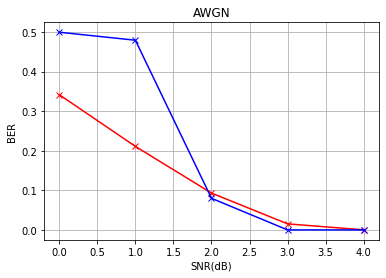

In [5]:
#without ecc
SNR = [0, 5, 10, 15, 20]
BER = [0.34173791458072586,0.2110691750104297,0.09312565185648728,0.015298615456821028,0.0001600307676261994] #corresponding BER 
plt.title("AWGN")
plt.xlabel("SNR(dB)") 
plt.ylabel("BER")
xSeq = range(len(SNR))
plt.plot(xSeq, BER, 'r-x')

#ecc
SNR = [0, 5, 10, 15, 20]
BER = [0.49950576241134755,0.4793715451606174,0.07988964069670422,0.000023336462244472255,0] #corresponding BER 
plt.title("AWGN")
plt.xlabel("SNR(dB)") 
plt.ylabel("BER")
xSeq = range(len(SNR))
plt.plot(xSeq, BER, 'b-x')
plt.grid(True)
plt.show()
